Affine coordinate space has parrallel lines eg. cartesian coordinate space

In [93]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
from scipy.ndimage import measurements
import matplotlib.cm as cm

Image moments by $$M_{ij} = \Sigma_x \Sigma_y x^{i} y^{j} f(x,y)$$
Centroid $$\bar{x} = M_{10}/M_{00}, \bar{y} = M_{01}/M_{00}$$

Central moments = $$ \Sigma_x \Sigma_y (x-\bar{x})^{i} (y-\bar{y})^{j} f(x,y) $$

h/w/c = (2048, 3072, 3)
[[ 18966.11334978 -20571.15708321]
 [-20571.15708321  62717.95920414]]
('Eigenvectors', array([-0.92964999, -0.36844389]), array([ 0.36844389, -0.92964999]))


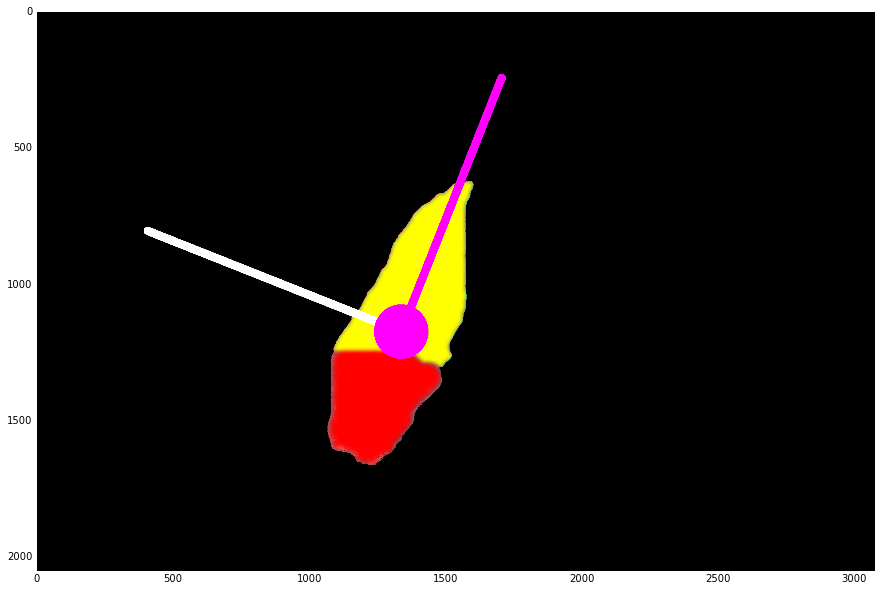

h/w/c = (2048, 3072, 3)
[[ 43705.70482409     99.74917534]
 [    99.74917534   2826.44814304]]
('Eigenvectors', array([-0.00244007,  0.99999702]), array([ 0.99999702,  0.00244007]))


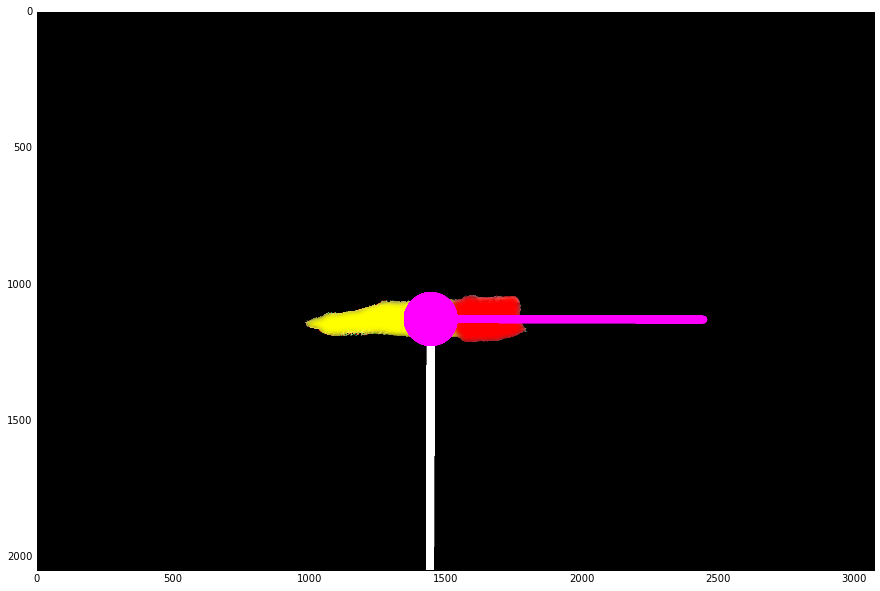

h/w/c = (3456, 5184, 3)
[[ 268316.70433814 -212892.77869908]
 [-212892.77869908  216579.92838533]]
('Eigenvectors', array([ 0.66309057,  0.74853918]), array([ 0.74853918, -0.66309057]))


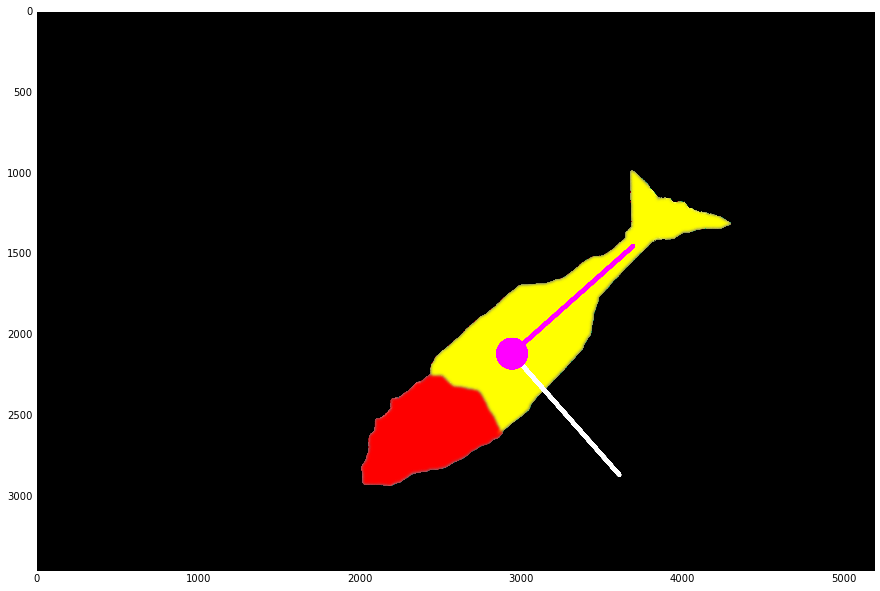

h/w/c = (2336, 3504, 3)
[[ 23337.98352773  18410.03290331]
 [ 18410.03290331  24000.02612912]]
('Eigenvectors', array([-0.7134345 ,  0.70072192]), array([-0.70072192, -0.7134345 ]))


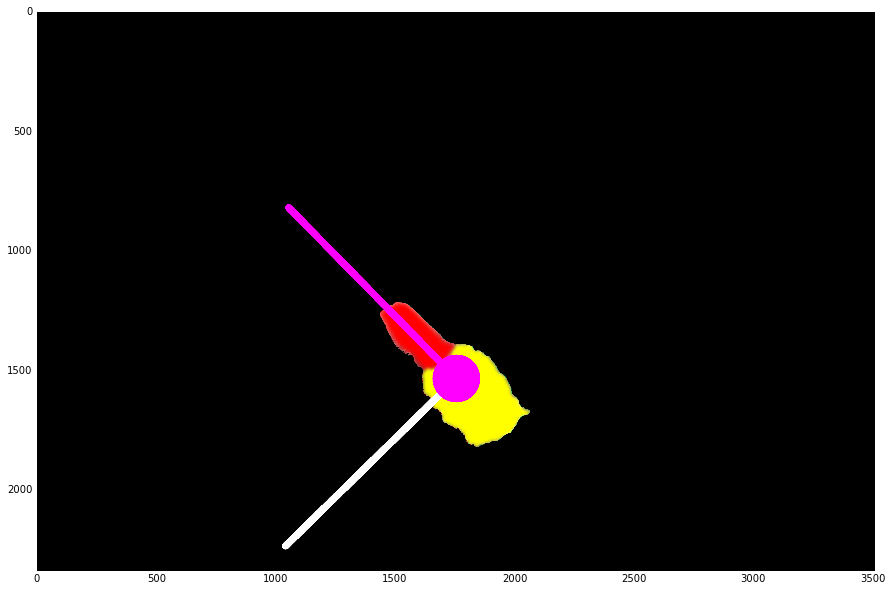

h/w/c = (2048, 3072, 3)
[[  6261.14764182   4984.71272507]
 [  4984.71272507  19524.14983495]]
('Eigenvectors', array([-0.94851412,  0.31673485]), array([-0.31673485, -0.94851412]))


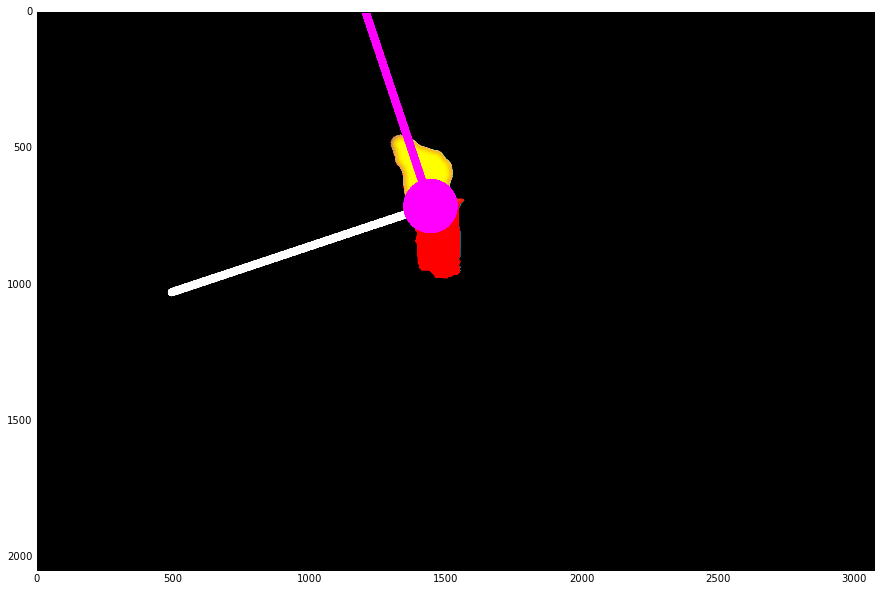

h/w/c = (3456, 5184, 3)
[[  20641.94603561   25659.02751724]
 [  25659.02751724  112064.6711346 ]]
('Eigenvectors', array([-0.96747409,  0.25297014]), array([-0.25297014, -0.96747409]))


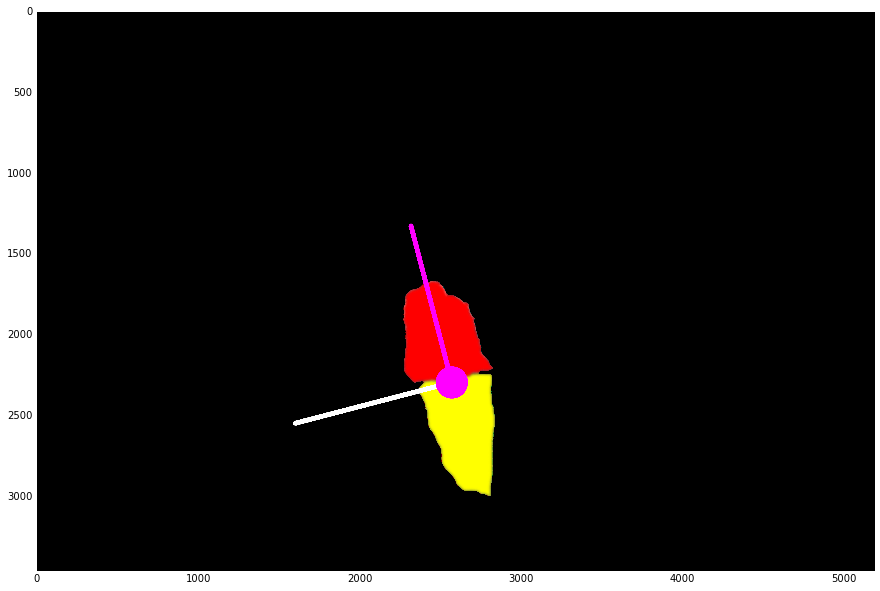

h/w/c = (2048, 3072, 3)
[[ 86776.75375669  24036.78744168]
 [ 24036.78744168  11202.97041133]]
('Eigenvectors', array([-0.2795025 ,  0.96014497]), array([ 0.96014497,  0.2795025 ]))


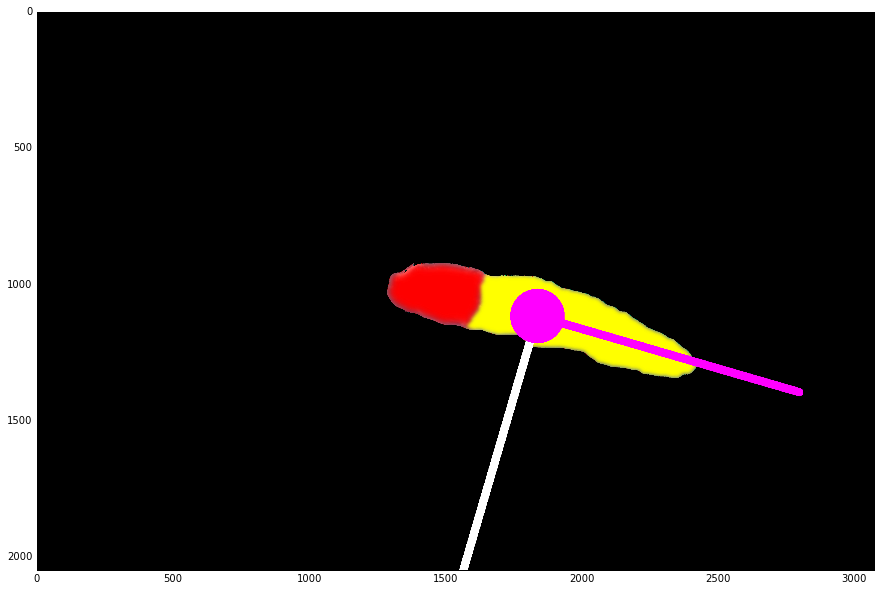

h/w/c = (2048, 3072, 3)
[[ 50976.6856164   47638.65354974]
 [ 47638.65354974  59381.02115356]]
('Eigenvectors', array([-0.73751882,  0.67532658]), array([-0.67532658, -0.73751882]))


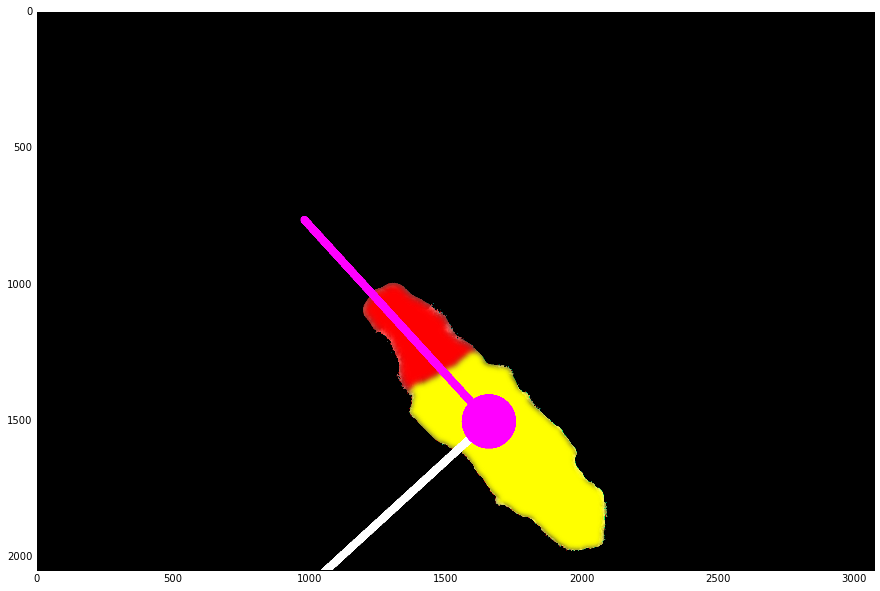

h/w/c = (2048, 3072, 3)
[[ 64909.40468217  19424.78687489]
 [ 19424.78687489  12970.49841367]]
('Eigenvectors', array([-0.3156157,  0.9488871]), array([ 0.9488871,  0.3156157]))


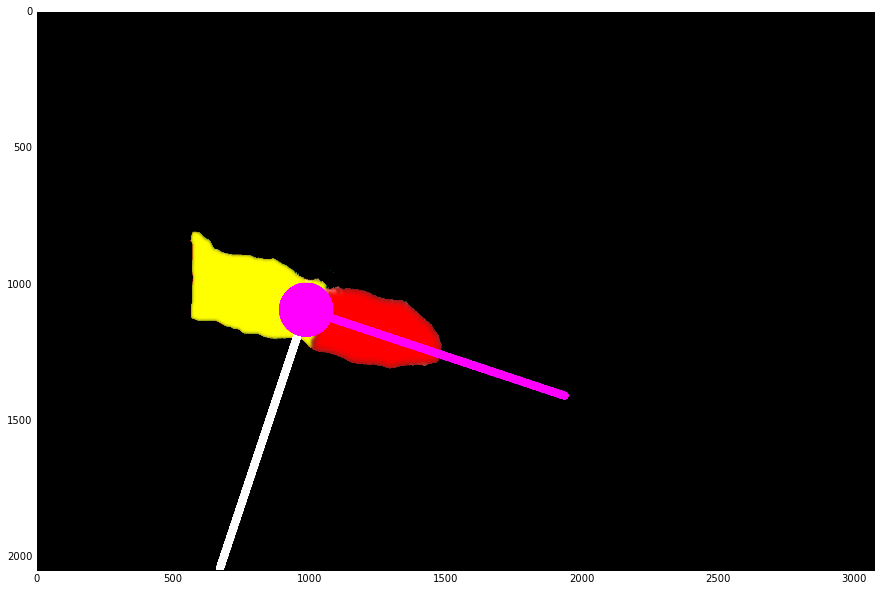

h/w/c = (2048, 3072, 3)
[[ 32243.87013877   1854.49429233]
 [  1854.49429233   1337.38305754]]
('Eigenvectors', array([-0.05968233,  0.99821742]), array([ 0.99821742,  0.05968233]))


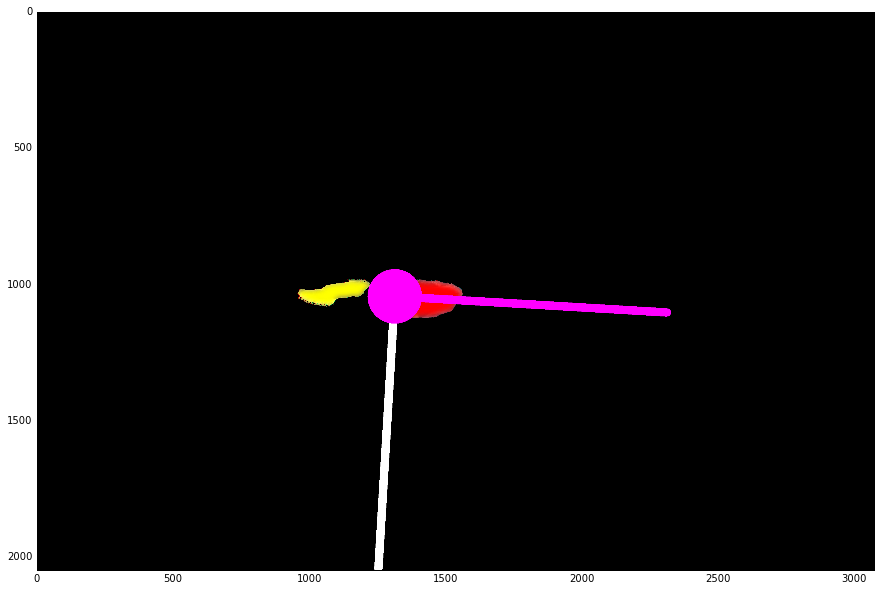

h/w/c = (2048, 3072, 3)
[[ 205513.86844632 -103958.86750516]
 [-103958.86750516   64349.07267417]]
('Eigenvectors', array([ 0.46812751,  0.88366093]), array([ 0.88366093, -0.46812751]))


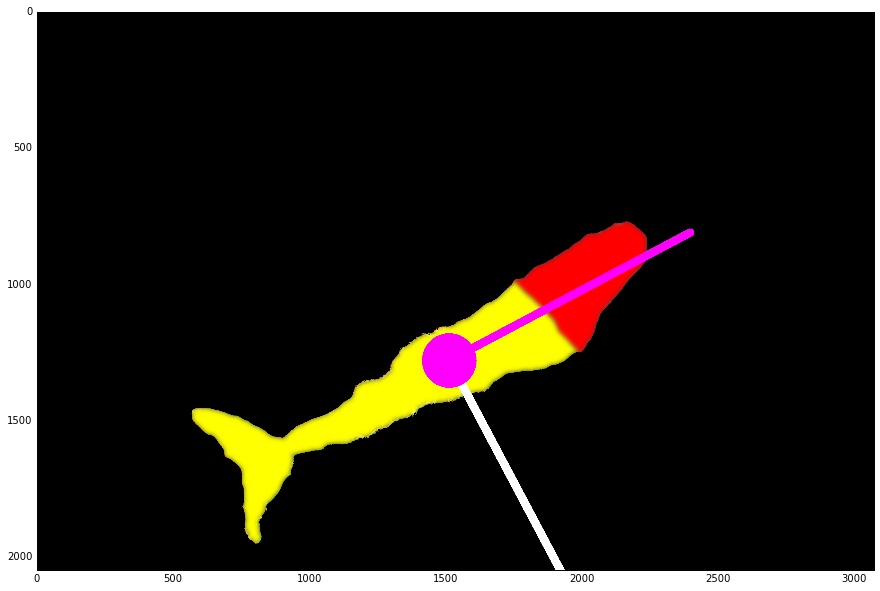

h/w/c = (2048, 3072, 3)
[[ 10520.86654632   9692.27624738]
 [  9692.27624738  27952.22124307]]
('Eigenvectors', array([-0.91341454,  0.40703057]), array([-0.40703057, -0.91341454]))


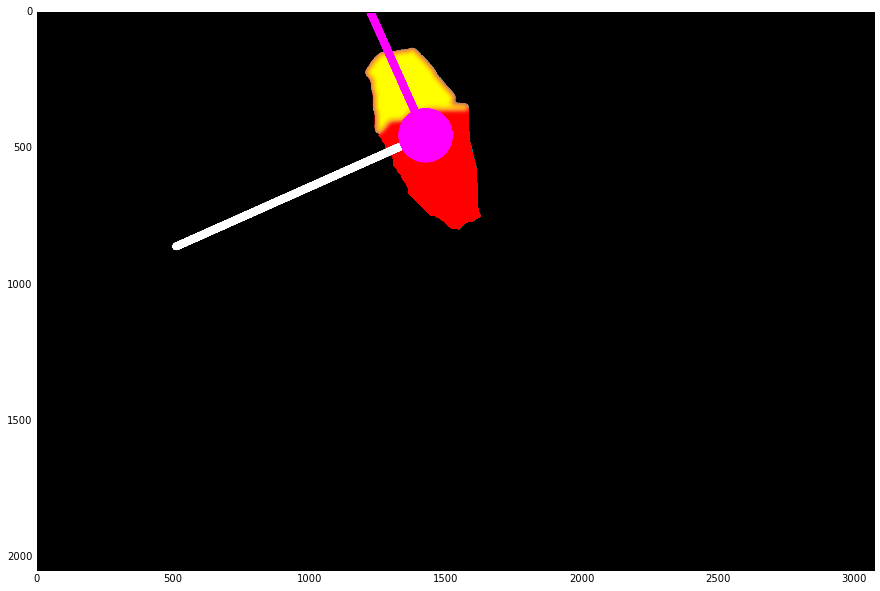

h/w/c = (2048, 3072, 3)
[[ 139281.81533333 -127487.02770011]
 [-127487.02770011  136307.03741413]]
('Eigenvectors', array([ 0.70297006,  0.71121944]), array([ 0.71121944, -0.70297006]))


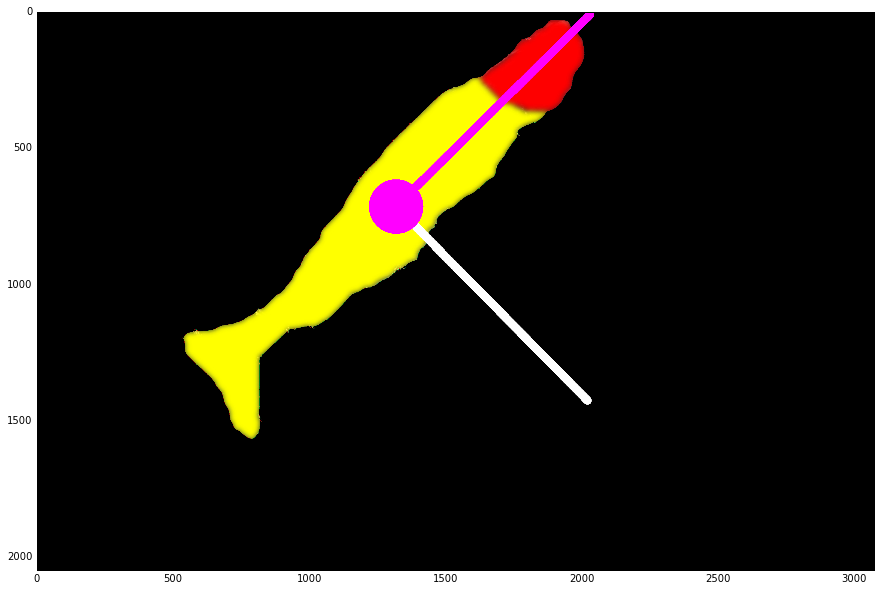

h/w/c = (3456, 5184, 3)
[[ 54779.64604819  10705.63900589]
 [ 10705.63900589   5057.16717728]]
('Eigenvectors', array([-0.20191105,  0.97940386]), array([ 0.97940386,  0.20191105]))


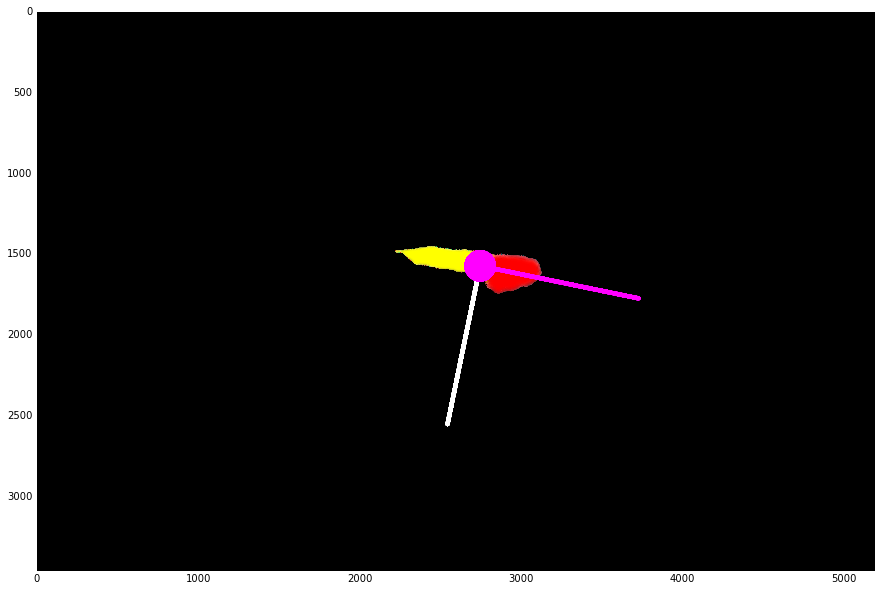

h/w/c = (2048, 3072, 3)
[[ 56640.76982127   7711.10921711]
 [  7711.10921711   1861.70869053]]
('Eigenvectors', array([-0.13678555,  0.99060068]), array([ 0.99060068,  0.13678555]))


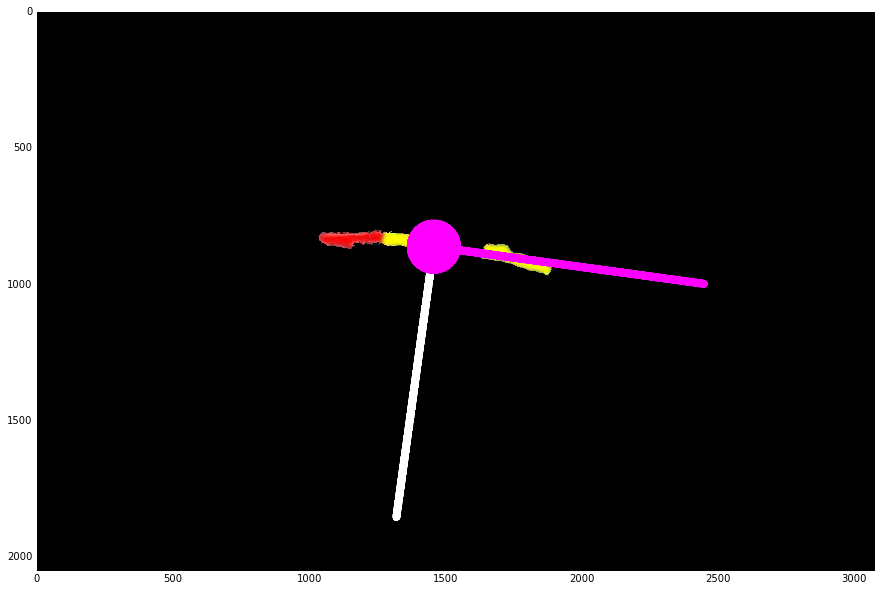

h/w/c = (2048, 3072, 3)
[[ 49876.67950617  -1899.43041027]
 [ -1899.43041027   3086.8672809 ]]
('Eigenvectors', array([ 0.04049503,  0.99917974]), array([ 0.99917974, -0.04049503]))


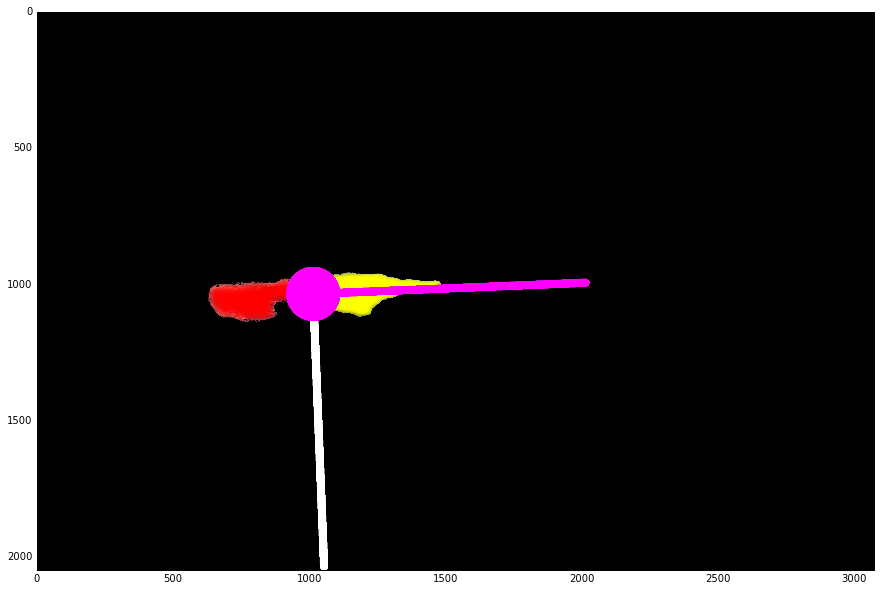

h/w/c = (2048, 3072, 3)
[[ 15577.9481769   11782.08172742]
 [ 11782.08172742  11937.38530379]]
('Eigenvectors', array([-0.65089005,  0.75917201]), array([ 0.75917201,  0.65089005]))


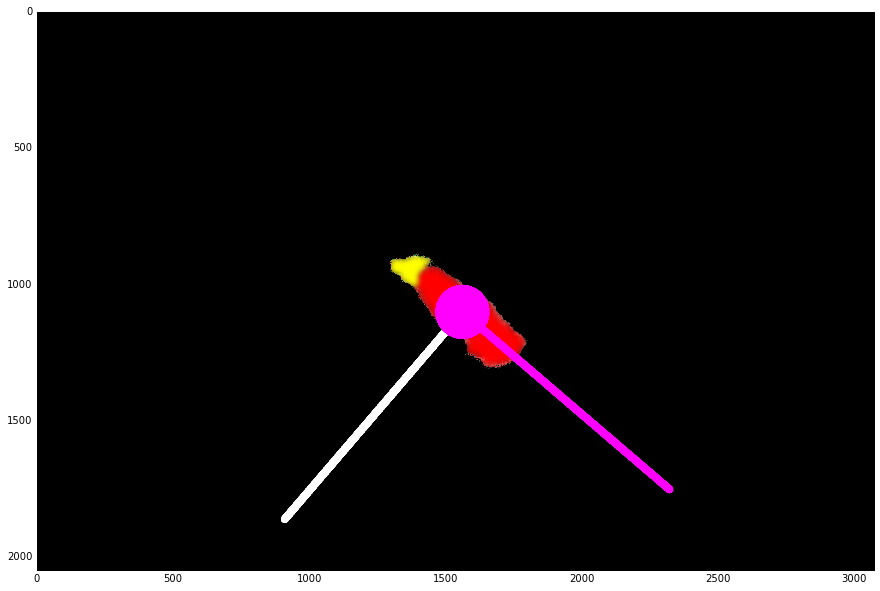

h/w/c = (2048, 3072, 3)
[[ 60388.61166082 -40074.4354268 ]
 [-40074.4354268   33520.21893244]]
('Eigenvectors', array([ 0.58401768,  0.81174094]), array([ 0.81174094, -0.58401768]))


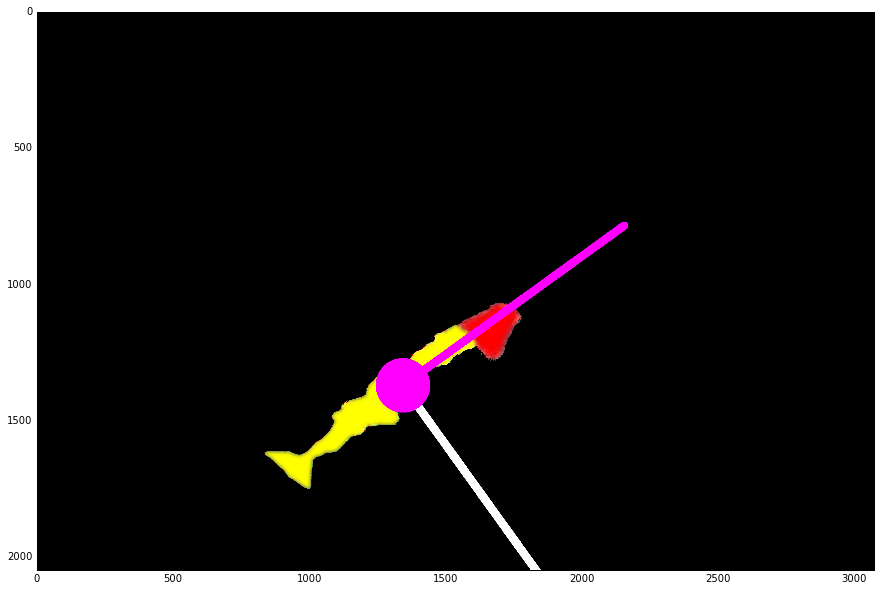

In [127]:
for i in range(22,40):

    imPath = glob.glob("/home/msmith/kaggle/whale/imgs/*/l_*")[i]

    orig = cv2.imread(imPath.replace("l_","w1_"))[:,:,::-1]
    mask = cv2.imread(imPath)[:,:,::-1]
    h,w,c = mask.shape
    mask = getRedYellow(mask)
    
    channel = 0 #Red
    img = mask.copy()
    h,w,c = img.shape
    print("h/w/c = {0}".format(tuple((h,w,c))))
    c = img[:,:,0]
    x,y = np.arange(w), np.arange(h)
    X,Y = np.meshgrid(x,y)

    m00 = (c).sum()
    m10 = (c*X).sum()
    m01 = (c*Y).sum()
    xBar = (m10/m00).astype(np.uint32)
    yBar = (m01/m00).astype(np.uint32)
    centroid = (xBar,yBar)
    
    m20 = (c*(X**2)).sum()
    m02 = (c*(Y**2)).sum()
    m11 = (c*Y*X).sum()
    
    mu20 = m20/m00 - xBar**2
    mu02 = m02/m00 - yBar**2
    mu11 = m11/m00 - xBar*yBar
    cov = np.array([[mu20,mu11],[mu11,mu02]])
    print(cov)
    
    eigenVals,eigenVectors = np.linalg.eig(cov)
    idx = abs(eigenVals).argsort() #Order eigen-system
    eigenVals    = eigenVals[idx]
    eigenVectors = eigenVectors[:,idx]

    e1 = eigenVectors[:,0]
    e2 = eigenVectors[:,1]
    print("Eigenvectors",e1,e2)
    
    
    def flip():
        if np.inner(np.array(m[0])-np.array(m[1]),eigenVectors[:,0])<0: #If (centroid of green - centroid of red) (dotProd) first eigenvector then flip direction 
            eigenVectors[:,0]*=-1
        if np.linalg.det(eigenVectors)<0: #Make sure determinant==1 so not mirror imaging
            eigenVectors[:,1]*=-1
    
    arroLen = 1000
    arrowToE1 = tuple((centroid + (e1)*arroLen).astype(np.uint16))
    arrowToE2 = tuple((centroid + (e2)*arroLen).astype(np.uint16))
    arrowFrom = tuple(map(int,centroid))
    
    dis = img.copy()
    cv2.line(dis,arrowFrom,arrowToE1,(255,255,255),30)
    cv2.line(dis,arrowFrom,arrowToE2,(255,0,255),30)
    cv2.circle(dis,centroid,100,(255,0,255),-1)
    plt.imshow(dis,cmap=cm.gray); plt.show()

In [ ]:
def getRedYellow(r):
    notRedOrYellow = (r[:,:,0] < 150) & (r[:,:,1] < 150) | (r[:,:,2] > 100)
    r[notRedOrYellow] = 0
    return r

print(eigenVectors)

angle = np.degrees(np.arccos(eigenVectors[0][0]))
affineTransform = cv2.getRotationMatrix2D(redCenter,angle,1.0)
photo=cv2.warpAffine(photo, affineTransform,(w,h),borderValue=0)
mask=cv2.warpAffine(mask, affineTransform, (w,h), borderValue=0)